# Ejercicio22

a) utilice el dataset OJ para predecir purchase. para esto utilice SVM con:

- kernel lineal, encontrando el mejor parametro C usando cross validation.
- kernel radial encontrando el mejor parametro gamma usando cross validation.

(segunda parte)

b) Utilice el dataset spam7 para predecir yesno. Para esto utilice SVM con:

- kernel lineal (encontrando el mejor parametro C usando cross validation.)
- kernel radial (encontrando el mejor parametro gamma usando cross validation.)
- con Precision, Recall, TF1 como los criterios de seleccion.

https://vincentarelbundock.github.io/Rdatasets/datasets.html

En la solución hago solamente la parte b) porque la parte a) es hacer exactamente lo mismo, solo que con otro set de datos.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
import sklearn.discriminant_analysis
import sklearn.ensemble
import sklearn.metrics
import sklearn.svm
from pandas.plotting import scatter_matrix
import gc

%matplotlib inline

In [27]:
# Carga datos
data = pd.read_csv('spam7.csv')
data.rename(columns={'yesno':'target'}, inplace=True)
print(data.keys())
# Descarta una de las columnas que no es util
data = data.drop(['Unnamed: 0'],axis=1)

# Normaliza los datos a media cero y desviacion estandar uno
predictors = list(data.keys())
predictors.remove('target')
data[predictors] = (data[predictors] - np.mean(data[predictors]))/np.std(data[predictors])
print(predictors)

Index(['Unnamed: 0', 'crl.tot', 'dollar', 'bang', 'money', 'n000', 'make',
       'target'],
      dtype='object')
['crl.tot', 'dollar', 'bang', 'money', 'n000', 'make']


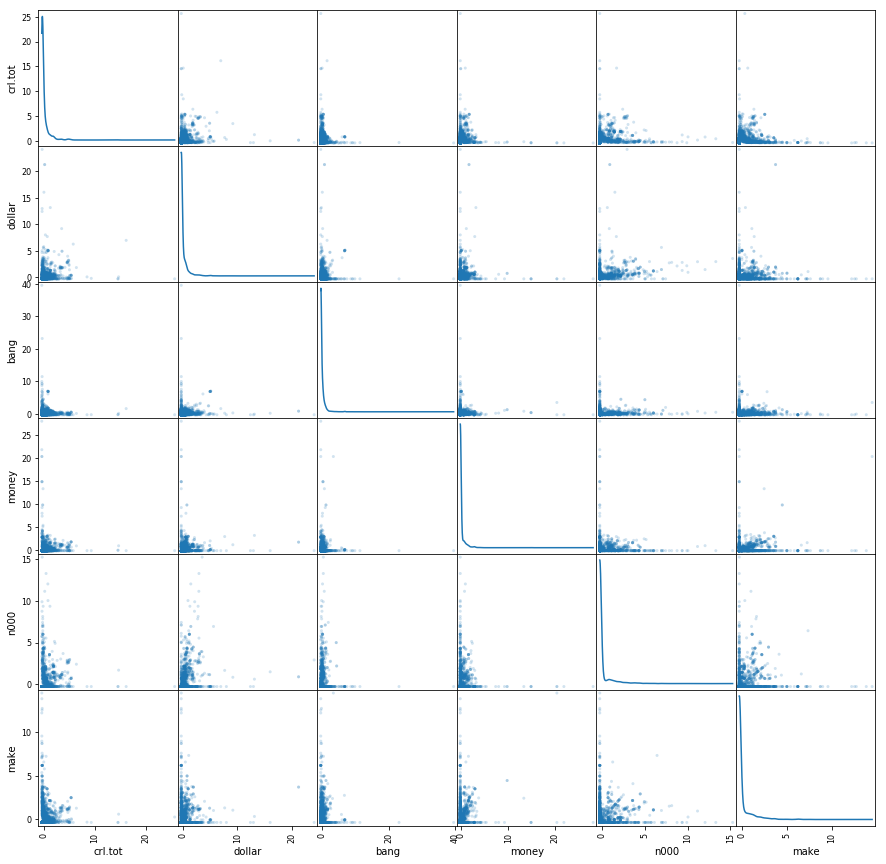

In [28]:
_ = scatter_matrix(data, alpha=0.2, figsize=(15, 15), diagonal='kde')

In [29]:
# Divide en train y test. Train se va a utilizar como cross validation
train_data, test_data = sklearn.model_selection.train_test_split(data, train_size=0.5)

C:\Users\Carlos Felipe\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [30]:
#Definimos una función para calcular la F1
def compute_F1(precision, recall):
    return 2.0 * (precision * recall) / (precision + recall)

In [31]:
#Hacemos cross_validation con el método de bootstraping. Hubiera podido ser k-fold también. Revisar el ejercicio 15 para ver más métodos.
def cross_validation(train_data, test_data, method, n_bootstrap=10):
    #Calcularemos el F1 score para train, validarion y test. Pero además, para cada uno de ellos, lo hacemos de manera separada para cada clase.
    # Es decir, predeciremos un F1 score para la clase 'Yes' y otro para la clase 'No'
    n_classes = len(list(set(train_data['target']))) #Aquí extraemos las clases, son dos.
    F1_train = np.ones((n_bootstrap, n_classes)) #Son matrices. 
    F1_valid = np.ones((n_bootstrap, n_classes))
    F1_test = np.ones((n_bootstrap, n_classes))
    for i in range(n_bootstrap):
        n_train = len(train_data)
        i_all = np.arange(n_train) # Todos los indices 
        i_train = np.random.choice(i_all, n_train) # Bootstraping los indices para train. Se eligen n_train índices aleatoriamente que pueden repetirse.
        i_validation =  np.array(list(set(i_all)-set(i_train))) # Los indices no usados van para validation. Esto lo hace set(i_all)-set(i_train)
        #Seleccionamos los datos para entrenar el modelo y para validarlo con los indices.
        sub_train_data=train_data[predictors].iloc[i_train]
        sub_ytrain_data=train_data['target'].iloc[i_train]
        
        sub_validation_data=train_data[predictors].iloc[i_validation]
        sub_yvalidation_data=train_data['target'].iloc[i_validation]
        
        #Fiteamos el modelo.
        method.fit(sub_train_data, sub_ytrain_data)
    
        #Calculamos precision y recall para cada set.
        precision_train, recall_train, _, _ = sklearn.metrics.precision_recall_fscore_support(sub_ytrain_data, 
                                                                                          method.predict(sub_train_data))
        precision_valid, recall_valid, _, _ = sklearn.metrics.precision_recall_fscore_support(sub_yvalidation_data, 
                                                                                          method.predict(sub_validation_data))
        precision_test, recall_test, _, _ = sklearn.metrics.precision_recall_fscore_support(test_data['target'], 
                                                                                        method.predict(test_data[predictors]))

        #Computamos el F1 score para cada set y cada clase.
        F1_train[i,:] = compute_F1(precision_train, recall_train)
        F1_valid[i,:] = compute_F1(precision_valid, recall_valid)
        F1_test[i,:] = compute_F1(precision_test, recall_test)
        #Devuelve un diccionario con toda la información.
    return {'F1_train_mean':F1_train.mean(axis=0), 
            'F1_train_std':F1_train.std(axis=0),
            'F1_valid_mean':F1_valid.mean(axis=0), 
            'F1_valid_std':F1_valid.std(axis=0),
            'F1_test_mean':F1_test.mean(axis=0), 
            'F1_test_std':F1_test.std(axis=0),
            'classes': method.classes_,
            'params': method.get_params()}

In [32]:
#Calculamos las estadísticas para cada valor de C del kernel lineal
n_c = 10
C_values = np.logspace(-2,2, n_c)

results_linear = {}
for i in range(n_c):
    linear = sklearn.svm.SVC(C=C_values[i], kernel='linear')
    results_linear[i] = cross_validation(train_data, test_data, linear)

In [33]:
#Calculamos las estadísticas para cada valor de gamma del kernel radial
n_g = 10
gamma_values = np.logspace(-2,2, n_g)

results_radial = {}
for i in range(n_g):
    radial = sklearn.svm.SVC(gamma=gamma_values[i], kernel='rbf')
    results_radial[i] = cross_validation(train_data, test_data, radial)

In [34]:
#Con este método graficamos los resultados
def plot_results(results, i_class=0, param='C'):
    n = len(results.keys())
    param_values = np.ones(n)
    f1_train = np.ones(n)
    f1_valid = np.ones(n)
    f1_test = np.ones(n)
    i = 0 
    for k in results.keys():
        param_values[i] = results[k]['params'][param]
        f1_train[i] = results[k]['F1_train_mean'][i_class]
        f1_valid[i] = results[k]['F1_valid_mean'][i_class]
        f1_test[i] = results[k]['F1_test_mean'][i_class]
        i += 1

    best = param_values[np.argmax(f1_test)]

    plt.plot(param_values, f1_train, color='red', label='TRAIN')
    plt.plot(param_values, f1_valid, color='blue', label='VALIDATION')
    plt.plot(param_values, f1_test, color='green', label='TEST')

    plt.semilogx()
    plt.title('Clase : {}. Best {}={:.2f}'.format(results[0]['classes'][i_class], param, best))
    plt.xlabel(param)
    plt.ylabel('F1 score')
    plt.ylim([0.7,0.95])
    plt.legend()

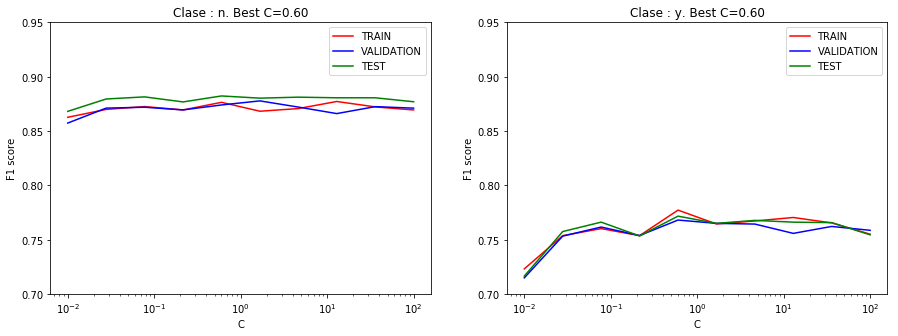

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_results(results_linear, i_class=0, param='C')
plt.subplot(1,2,2)
plot_results(results_linear, i_class=1, param='C')

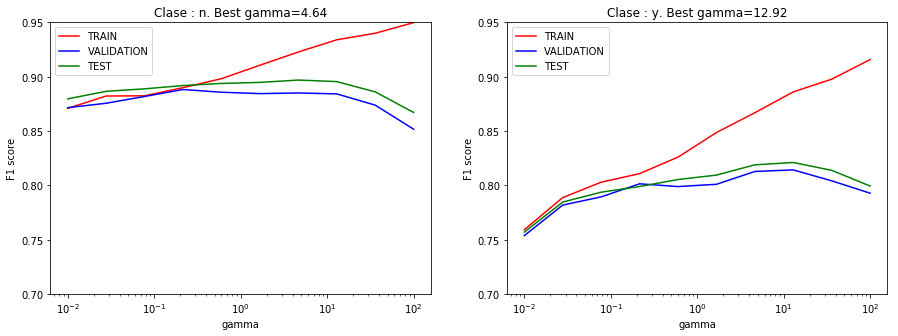

In [36]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plot_results(results_radial, i_class=0, param='gamma')
plt.subplot(1,2,2)
plot_results(results_radial, i_class=1, param='gamma')